In [15]:
!pip install rasterio geopandas shapely

In [16]:
import os

import cv2  # For image processing
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For displaying images
import pandas as pd
import geopandas as gpd
import os
import shutil
import glob
import pickle

import rasterio
from rasterio.plot import reshape_as_image
from rasterio.features import rasterize

from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import matplotlib.pyplot as plt

from typing import Iterable, Any, List, Tuple, Callable

In [17]:
base_dataset_path = '/kaggle/input/deforestation-in-ukraine/'
development_dataset_path = '/kaggle/working/smaller_dev_dataset/'
df = gpd.read_file('/kaggle/input/deforestation-in-ukraine/deforestation_labels.geojson')

In [18]:
df.head()

,img_date,tile,geometry
0,2016-04-09,36UXA,"POLYGON ((35.79130 50.17406, 35.79277 50.17354..."
1,2016-04-09,36UXA,"POLYGON ((35.77653 50.10271, 35.77810 50.10318..."
2,2016-04-09,36UXA,"POLYGON ((35.78621 50.01277, 35.78616 50.01369..."
3,2016-04-09,36UXA,"POLYGON ((35.78007 50.00556, 35.78189 50.00557..."
4,2016-04-09,36UXA,"POLYGON ((35.79781 49.99568, 35.79908 49.99582..."


In [191]:
class ImageLoader:
    '''lazy'''
    def __init__(self, base_dir: str):
        # self.pattern = '**/*.jp2'
        self.pattern = '**/*_TCI.jp2'
        self.image_files = glob.glob(os.path.join(base_dir, self.pattern), recursive=True)
        
    def __iter__(self):
        for image_file in self.image_files:
            # image = ImageLoader._load_image(image_file)
            # image = self._load_image_rasterio(image_file)
            image = self._load_image(image_file)
            print(image.shape)
            yield image

    def _load_image(self, image_path, max_dimension=1024):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if img is None:
            raise ValueError(f"Image not found or cannot be opened: {image_path}")
        
        height, width = img.shape[:2]
        scale = max_dimension / max(height, width)
        resized_img = cv2.resize(img, (int(width * scale), int(height * scale)), interpolation=cv2.INTER_AREA)
        resized_img = resized_img.reshape(int(width * scale), int(height * scale), -1)
        
        # gray = self._grayscale(resized_image)
        # gray = 
        # return self._normalize(gray)
        # return gray
        return resized_img

    def _load_image_rasterio(self, image_path, max_dimension=1024):
        with rasterio.open(image_path, "r", driver='JP2OpenJPEG') as src:
            raster_image = src.read()  # Shape: (bands, height, width)
        
        bands, height, width = raster_image.shape
        scale = max_dimension / max(height, width)
        new_height, new_width = int(height * scale), int(width * scale)
        
        resized_bands = [cv2.resize(raster_image[i], (new_width, new_height), interpolation=cv2.INTER_AREA) for i in range(bands)]
        resized_image = np.stack(resized_bands, axis=0).reshape(new_height, new_width, -1)

        # gray = self._grayscale(resized_image)
        # return self._normalize(gray)
        return resized_image

    def _normalize(self, image) -> np.ndarray:
        min_val, max_val = image.min(), image.max()
        scaled_img = 255 * (image - min_val) / (max_val - min_val)
        # print(scaled_img.min(), scaled_img.max())
        return scaled_img.astype(np.intp)
    
    def _grayscale(self, image):
        if len(image.shape) >= 3:
            # return np.mean(image.copy(), axis=2)
            return cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY).astype(np.intp)
            
        return image.copy()

def load_images(dir: str, ext: str='jp2', n_images: int=0) -> List[np.ndarray]:
    image_loader = ImageLoader(dir)
    
    if n_images == 0:
        return [img for img in image_loader]

    # else
    images = []
    for i, img in enumerate(image_loader):
        images.append(img)
        if i >= n_images: break
    
    return images


In [192]:
# images = load_images('/kaggle/working')
images = load_images(base_dataset_path, n_images=21)

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)


In [193]:
images[4].max()

255

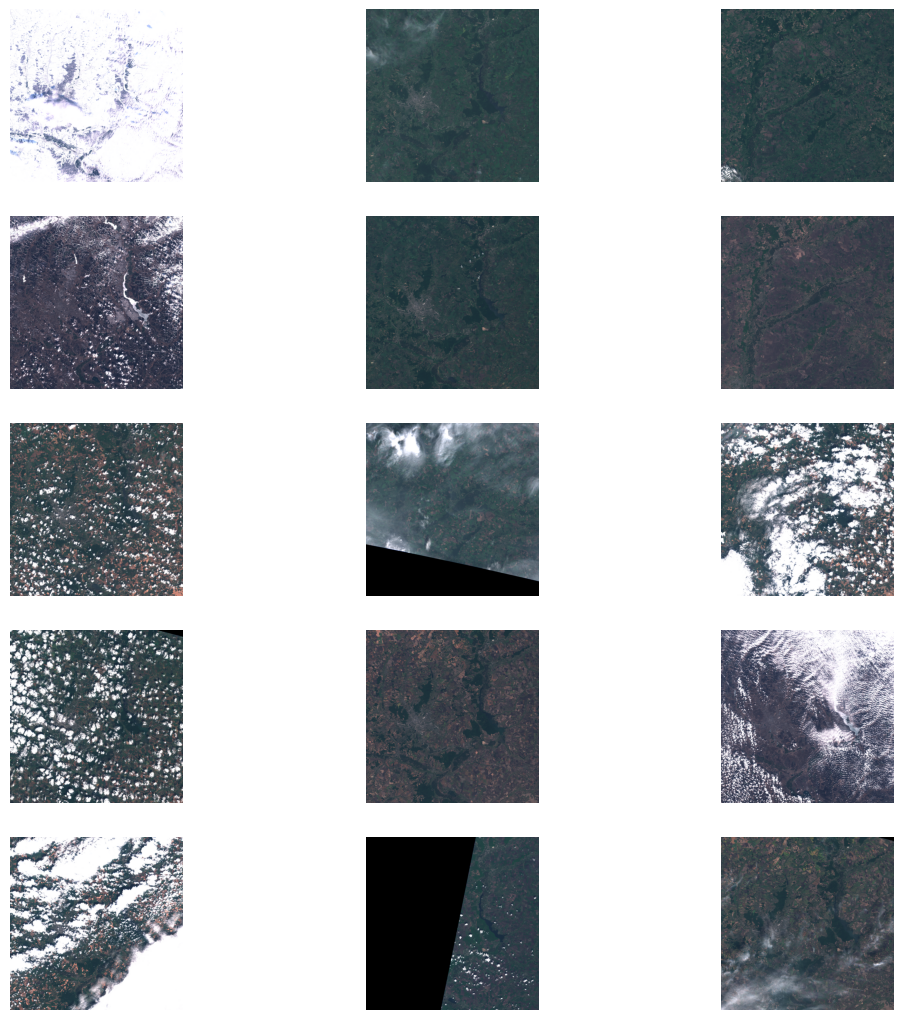

In [194]:
# list(os.walk(base_dataset_path))
# preprocess_and_save_images(base_dataset_path, development_dataset_path, n_images=32)

fig, ax = plt.subplots(ncols=3, nrows=5, figsize=(13, 13))
ax = ax.flatten()

for i, image in enumerate(images[:15]):
    ax[i].imshow(image, cmap='gray')
    ax[i].axis('off')

plt.show()

In [203]:
class FeatureMatcher:

    def __init__(self):
        self.sift = cv2.SIFT_create()
        self.bf = cv2.BFMatcher()

    def _normalize_image(self, img: np.ndarray) -> np.ndarray:
        '''normalize if images are larger than uint8'''
        if img.max() > 255:
            img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        return img.astype(np.uint8)

    def find_features_px(self, img1: np.ndarray, img2: np.ndarray):
        '''feature matching for images'''
        img1 = self._normalize_image(img1)
        img2 = self._normalize_image(img2)

        if len(img1.shape) > 2:
            img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
        if len(img2.shape) > 2:
            img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

        kp1, des1 = self.sift.detectAndCompute(img1, None)
        kp2, des2 = self.sift.detectAndCompute(img2, None)

        return kp1, des1, kp2, des2

    def find_features_path(self, img_path_1: str, img_path_2: str):
        '''feature matching but from path'''
        img1 = cv2.imread(img_path_1, cv2.IMREAD_UNCHANGED)
        img2 = cv2.imread(img_path_2, cv2.IMREAD_UNCHANGED)

        if img1 is None or img2 is None:
            raise ValueError(f"Images at {img_path_1} or {img_path_2} could not be opened.")
        
        return self.find_features_px(img1, img2)

    def compare_features(self, des1, des2, threshold=0.75):
        '''filter good matches pairwise'''
        matches = self.bf.knnMatch(des1, des2, k=2)
        good_matches = [m for m, n in matches if m.distance < threshold * n.distance]
        # return len(good_matches)
        return good_matches

    def draw_matches(self, img1, img2, threshold=0.75):
        '''the name of function speaks for itself'''
        kp1, des1, kp2, des2 = self.find_features_px(img1, img2)

        matches = self.bf.knnMatch(des1, des2, k=2)
        # good_matches = [m for m, n in matches if m.distance < threshold * n.distance]
        good_matches = self.compare_features(des1, des2, threshold)

        matched_img = cv2.drawMatches(
            img1, kp1, img2, kp2, good_matches, None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )

        return matched_img

In [201]:
image_1 = images[1].copy()
image_2 = images[3].copy()

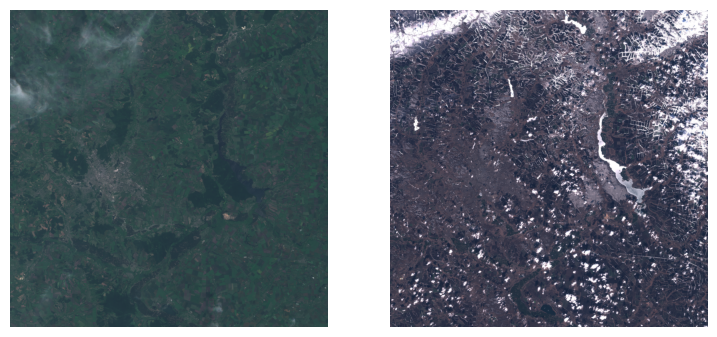

In [202]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9, 9))
ax = ax.flatten()

for i, image in enumerate([image_1, image_2]):
    ax[i].imshow(image, cmap='gray')
    ax[i].axis('off')

plt.show()

In [204]:
f_matcher = FeatureMatcher()

In [228]:
# smaller threshold - less matches

matched_images = f_matcher.draw_matches(image_1, image_2, threshold=0.90)

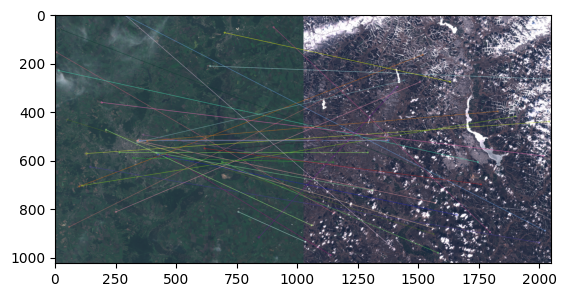

In [230]:
# feature matches are chaotic -> probably transform from img1 to img2 does not exist

plt.imshow(matched_images)

In [231]:
# average abs difference to ensure images are not the same

np.abs(image_1 - image_2).sum() / image_1.size

126.05772431691487

In [232]:
image_similar_1 = images[4].copy()
image_similar_2 = images[10].copy()

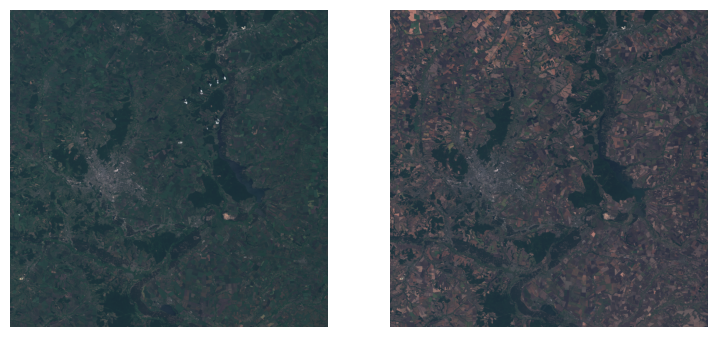

In [233]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9, 9))
ax = ax.flatten()

for i, image in enumerate([image_similar_1, image_similar_2]):
    ax[i].imshow(image, cmap='gray')
    ax[i].axis('off')

plt.show()

In [234]:
# smaller threshold - less matches

matched_similar_images = f_matcher.draw_matches(image_similar_1, image_similar_2, threshold=0.5)

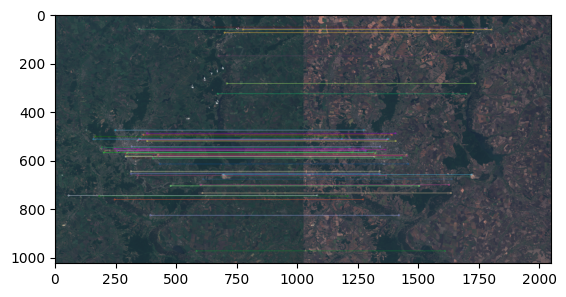

In [235]:
# feature matches are parallel -> translation transform to match images (to minimize MSE between points)

plt.imshow(matched_similar_images)
plt.show()

In [174]:
!pip freeze > requirements.txt

In [190]:
import functools
    
with open('/kaggle/working/requirements.txt', 'r') as file:
    lines = functools.reduce(lambda x, y: x + '\n' + y, [line.strip() for line in file])

print(lines)

absl-py==1.4.0
accelerate==0.34.2
affine==2.4.0
aiobotocore==2.15.1
aiofiles==22.1.0
aiohttp @ file:///home/conda/feedstock_root/build_artifacts/aiohttp_1713964853148/work
aioitertools==0.12.0
aiosignal @ file:///home/conda/feedstock_root/build_artifacts/aiosignal_1667935791922/work
aiosqlite==0.20.0
albucore==0.0.17
albumentations==1.4.17
alembic==1.13.3
altair==5.4.1
annotated-types==0.7.0
annoy==1.17.3
ansicolors==1.1.8
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1717693030552/work
apache-beam==2.46.0
appdirs==1.4.4
archspec @ file:///home/conda/feedstock_root/build_artifacts/archspec_1708969572489/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1692818318753/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1695386546427/work
array_record==0.5.1
arrow @ file:///home/conda/feedstock_root/build_artifacts/arrow_1696128962909/work
arviz==0.20.0
astroid==3.3.4
asttokens @ file:///home/c